# Introduction

1. **Character (Research Topic):**  
   This project explores how chemical reaction systems can be modeled using systems of ordinary differential equations (ODEs) and plots them over time. 

2. **Setting (Niche):**  
   A Python framework was developed to simulate nonlinear and linear reaction systems with reversible and irreversible pathways.

3. **Problem:**  
   Standard analytical methods are often limited to linear or simple reactions, or could be non-generalized. There is a need for a flexible, numerical modeling tool for more complex and general systems. When we don't know exactly how our reaction advances more generally, this program also helps visualize it.

4. **Solution:**  
   We built a modular simulation package that takes user-defined species (products and reagents), reactions (with optional reversibility), and initial concentrations. It then computes and visualizes the evolution of concentrations over time using `solve_ivp`.


# Materials & Methods

The core of this package is the usage of ODEs that describe the time evolution of concentrations for each species in a reaction network (be it a linear or non-linear ODE). 

There are two main modeling approaches implemented:

### 1. **Matrix-Based Linear Systems**
This method assumes linear rate laws (first-order reactions). A matrix **M** is constructed from the reactions, and the system is defined as:

$$ \frac{dy}{dt} = M y $$

Where **y** is the concentration vector.

### 2. **Function-Based Nonlinear Systems**
In this version, reactions can follow nonlinear laws (e.g., second order like A + B → C). The right-hand side is built by interpreting the reaction terms directly.

Both systems use `scipy.integrate.solve_ivp` to solve the equations numerically over a given time interval.

**Tools used**:
- `NumPy`: matrix and array operations
- `SciPy`: solving ODEs
- `Matplotlib`: plotting
- `SymPy` (partially implemented): for symbolic solutions


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def build_RHS(species, reactions):
    species_idx = {s: i for i, s in enumerate(species)}

    def f(t,y):
        dy= np.zeros(len(species))
        for reactants, products, kf, kr in reactions:
            rate_fwd = kf
            for r in reactants:
                rate_fwd *= y[species_idx[r]]
            for r in reactants:
                dy[species_idx[r]] -= rate_fwd
            for p in products:
                dy[species_idx[p]] += rate_fwd
            if kr is not None:
                rate_rev = kr
                for p in products:
                    rate_rev *= y[species_idx[p]]
                for p in products:
                    dy[species_idx[p]] -= rate_rev
                for r in reactants:
                    dy[species_idx[r]] += rate_rev
        return dy
    return f

def solve_reactions(species, reactions, y0_vals, t_span=(0, 10), t_eval=None):
    rhs = build_RHS(species, reactions)
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 300)
    sol = solve_ivp(rhs, t_span, y0_vals, method='RK45', t_eval=t_eval)
    return sol

def plot_solution(sol, species):
    for i, s in enumerate(species):
        plt.plot(sol.t, sol.y[i], label=s)
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title('Species concentration over time')
    plt.legend()
    plt.show()


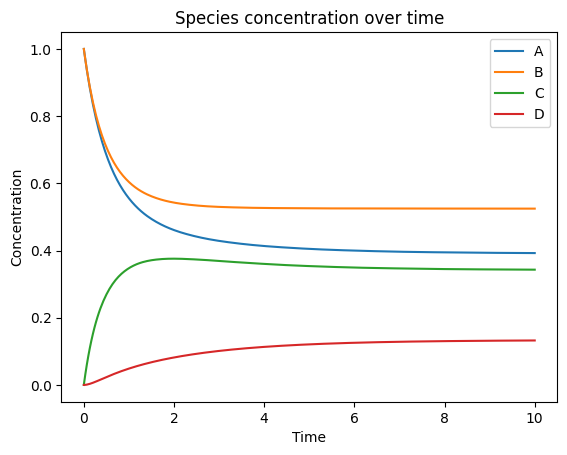

In [2]:
# Define system and run simulation
species_test = ['A', 'B', 'C', 'D']
reactions_test = [
    (['A', 'B'], ['C'], 1.0, 0.5),
    (['C'], ['A', 'B'], 0.1, None),
    (['A', 'C', 'B'], ['D', 'B'], 0.5, 0.5)
]
y0_vals = [1.0, 1.0, 0.0, 0.0]

sol = solve_reactions(species_test, reactions_test, y0_vals)
plot_solution(sol, species_test)


# Results

The plot above shows the concentration profiles of each species over time. As expected, the concentrations evolve based on the competition between forward and reverse reaction rates.

- The concentration of species **C** initially increases due to A + B → C.
- Over time, the reversibility and multi-species reaction C + A + B → D + B affects the balance.
- Eventually, a dynamic equilibrium may form depending on rate constants.

The model captures the nonlinear interactions effectively.


# Discussion

This approach allows flexible modeling of complex reaction networks, beyond what linear algebra-based systems can represent.

### Strengths:
- Easily handles reversible and irreversible reactions
- Works for nonlinear kinetics (e.g., A + B → C)
- Clear visualization of species evolution

### Limitations:
- Computational efficiency may decrease for large systems
- Symbolic methods still need to be fully implemented

Future work may include symbolic solutions, automated steady-state detection, or GUI-based interfaces using tools like Streamlit.
